In [53]:
# create bp for 2 ROI into csv - using panda dataframe
import mne
import matplotlib.pyplot as plt
from mne.time_frequency import psd_array_multitaper
from scipy.integrate import simps
import numpy as np
import seaborn as sns
import pandas as pd
precleaned_epochs_path = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/full_epochs_data/'
fmin = 1
fmax = 100

# all subject 63
subjs=['02', '04','07', '11', '12', '14', '16', '18', '19', '21', '22', '26', '28', '30',
       '32', '34', '36', '37', '38', '40', '42', '50', '51', '52', '53', '54', '55', '56',
       '58', '59','60', '63', '65', '67', '68', '70', '72', '73', '78', '83', '87', '88', 
       '90', '91', '93', '94', '95', '96','10','25','29','39','57','64','69','80','81','82',
       '35','71','79','76','77']


listNovices = ['02', '04', '07', '10', '11', '12', '14', '16', '18', '19', '21', '22', '26', 
 '28', '29', '30', '32', '34', '35', '36', '37', '38','39', '40', '42', '81', '82', 
 '83', '87', '88', '90', '91', '93', '94', '95', '96']
listExperts = ['25', '50', '51', '52',
 '53', '54', '55', '56', '57', '58', '59', '60', '63', '64', '65', '67','68', '69' ,'70' ,
               '71', '72', '73', '76', '77', '78' ,'79', '80']

ROIs = {'frontal':['Fz','F1','F3','AF3','AFz','AF4','F4','F2'],
       'occipital':['POz','Oz','O1','O2']}

CondStates={'baseline':{'VD':['111.0','112.0'],'FA':['211.0','212.0'],'OP':['311.0','312.0']},
           'safe':{'VD':['121.0','122.0'],'FA':['221.0','222.0'],'OP':['321.0','322.0']},
           'threat':{'VD':['131.0','132.0'],'FA':['231.0','232.0'],'OP':['331.0','332.0']}}

wavebands = {'alpha':[8,12],'theta':[3,7],'beta':[13,24],'lowG':[25,40],'highG':[60,90]}


frames_subject = []
for subj in subjs:
    precleaned_epochs_fname = precleaned_epochs_path + 'subj0'+subj+'full_epo.fif'
    precleaned_epochs = mne.read_epochs(precleaned_epochs_fname, preload=True)
    frames_condition = []
    for condition in CondStates.keys():
        frames_state=[]
        for state in CondStates[condition].keys():
#             precleaned_epochs_engineering = precleaned_epochs.copy()
            precleaned_epochs_selected = precleaned_epochs[CondStates[condition][state]]
            frames_ROI=[]
            for roi in ROIs.keys():
                precleaned_epochs_engineering = precleaned_epochs_selected.copy()
                data = precleaned_epochs_engineering.pick_channels(ROIs[roi])._data
                frames_waveband = []
                for waveband in wavebands.keys():
                    low,high = wavebands[waveband]
                    bpAbs_4Epochs=[]
                    bpRelative_4Epochs=[]
                    for num_epochs in range(data.shape[0]):
                        sf = precleaned_epochs_engineering.info['sfreq']
                        bpAbs_4allchannels = []
                        bpRelative_4allchannels = []
                        psd, freqs = psd_array_multitaper(data[num_epochs], sf, fmin = fmin, fmax =fmax,
                                          adaptive=True,normalization='full',verbose=0)
                        psd = np.log10(psd*10e12)
                        # average over channels
                        psd = psd.mean(axis=0)
                        freq_res = freqs[1] - freqs[0]
                        bp_total = simps(psd, dx=freq_res)
                        idx_band = np.logical_and(freqs >= low, freqs <= high)
                        bp_abs = simps(psd[idx_band], dx=freq_res)
                        bp_relative = bp_abs/bp_total
                        bpAbs_4Epochs.append(bp_abs)
                        bpRelative_4Epochs.append(bp_relative)
                    bpAbs_mean4Epochs = np.array(bpAbs_4Epochs).mean()
                    bpRelative_mean4Epochs = np.array(bpRelative_4Epochs).mean()
                        
                    if subj in listNovices:
                        group = ['novice']
                    elif subj in listExperts:
                        group = ['expert']
                    data_df_psd = {'subj':[subj],'ROI':[roi],'state':[state],'condition':[condition],
                                   'group':group,'rhythm':[waveband],'AbsBP':[bpAbs_mean4Epochs],
                                  'RelativeBP':[bpRelative_mean4Epochs]}
                    df_psd_perWaveband = pd.DataFrame(data_df_psd)
                    frames_waveband.append(df_psd_perWaveband)
                df_psd_perROI = pd.concat(frames_waveband,ignore_index=True)
                frames_ROI.append(df_psd_perROI)
            df_psd_perState = pd.concat(frames_ROI,ignore_index=True)
            frames_state.append(df_psd_perState)
        df_psd_perCondition = pd.concat(frames_state,ignore_index=True)
        frames_condition.append(df_psd_perCondition)
    df_psd_perSubject = pd.concat(frames_condition,ignore_index=True)
    frames_subject.append(df_psd_perSubject)
df_psd = pd.concat(frames_subject,ignore_index=True)
df_psd.to_csv(path_or_buf='/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/full_epochs_data/df_bp_log_cluster.csv',index = False)
print('finished')

Reading /home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/full_epochs_data/subj002full_epo.fif ...
    Found the data of interest:
        t =       0.00 ...    2000.00 ms
        0 CTF compensation matrices available
1288 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated


KeyboardInterrupt: 

In [48]:
df_psd.to_csv(path_or_buf='/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/full_epochs_data/df_bp.csv',index = False)

In [144]:
### get bp matrice for 6 baseline  expert/novice  VD FA OP -baseline

import pickle
import mne
import matplotlib.pyplot as plt
from mne.time_frequency import psd_array_multitaper
from scipy.integrate import simps
import numpy as np
import seaborn as sns
import pandas as pd
import sys
from mne.channels import find_ch_connectivity
from scipy.stats.distributions import f,t
from mpl_toolkits.axes_grid1 import make_axes_locatable
precleaned_epochs_path = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/full_epochs_data/'
fmin = 1
fmax = 100
def getBpAbsAndRelative4allChannels(epochs,rhythm):
    wavebands = {'alpha':[8,12],'theta':[3,7],'beta':[13,24],'lowG':[25,40],'highG':[60,90]}
    if rhythm in wavebands.keys():
        low,high =  wavebands[rhythm]
    else:
        print('not such rhythm')
    bpAbs_4Epochs=[]
    bpRelative_4Epochs=[]
    data = epochs.get_data(picks=['eeg'])
    for num_epochs in range(data.shape[0]):
        sf = epochs.info['sfreq']
        bpAbs_4allchannels = []
        bpRelative_4allchannels = []
        psd, freqs = psd_array_multitaper(data[num_epochs], sf, fmin = 1, fmax =100,
                          adaptive=True,normalization='full',verbose=0)
        psd= np.log10(psd*10e12)
        freq_res = freqs[1] - freqs[0]
        bp_total = simps(psd, dx=freq_res)
        idx_band = np.logical_and(freqs >= low, freqs <= high)
        bp_abs = simps(psd[:,idx_band], dx=freq_res)
        bp_relative = bp_abs/bp_total
        bpAbs_4Epochs.append(bp_abs)
        bpRelative_4Epochs.append(bp_relative)
    bpAbs_mean4Epochs = np.append([bpAbs_4Epochs[0]],bpAbs_4Epochs[1:],axis = 0).mean(axis=0)
    bpRelative_mean4Epochs = np.append([bpRelative_4Epochs[0]],bpRelative_4Epochs[1:],axis = 0).mean(axis=0)
    return bpAbs_mean4Epochs,bpRelative_mean4Epochs

def getBpAbs4allChannels(epochs,rhythm):
    wavebands = {'alpha':[8,12],'theta':[3,7],'beta':[13,24],'lowG':[25,40],'highG':[60,90]}
    if rhythm in wavebands.keys():
        low,high =  wavebands[rhythm]
    else:
        print('not such rhythm')
    bpAbs_4Epochs=[]
    data = epochs.get_data(picks=['eeg'])
    for num_epochs in range(data.shape[0]):
        sf = epochs.info['sfreq']
        bpAbs_4allchannels = []
        psd, freqs = psd_array_multitaper(data[num_epochs], sf, fmin = 1, fmax =100,
                          adaptive=True,normalization='full',verbose=0)
        psd= np.log10(psd*10e12)
        freq_res = freqs[1] - freqs[0]
        idx_band = np.logical_and(freqs >= low, freqs <= high)
        bp_abs = simps(psd[:,idx_band], dx=freq_res)
        bpAbs_4Epochs.append(bp_abs)
    bpAbs_mean4Epochs = np.append([bpAbs_4Epochs[0]],bpAbs_4Epochs[1:],axis = 0).mean(axis=0)
    return bpAbs_mean4Epochs

# alpha bp clustering test - VD OP

subjs=['02', '04','07', '11', '12', '14', '16', '18', '19', '21', '22', '26', '28', '30',
       '32', '34', '36', '37', '38', '40', '42', '50', '51', '52', '53', '54', '55', '56',
       '58', '59','60', '63', '65', '67', '68', '70', '72', '73', '78', '83', '87', '88', 
       '90', '91', '93', '94', '95', '96','10','25','29','39','57','64','69','80','81','82',
       '35','71','79','76','77']

# states_codes={'VD':['111.0','112.0','121.0','122.0','131.0','132.0'],
#               'FA':['211.0','212.0','221.0','222.0','231.0','232.0'],
#               'OP':['311.0','312.0','321.0','322.0','331.0','332.0']}

states_codes={'VD':['111.0','112.0'],
              'FA':['211.0','212.0'],
              'OP':['311.0','312.0']}

listNovices = ['02', '04', '07', '10', '11', '12', '14', '16', '18', '19', '21', '22', '26', 
 '28', '29', '30', '32', '34', '35', '36', '37', '38','39', '40', '42', '81', '82', 
 '83', '87', '88', '90', '91', '93', '94', '95', '96']
listExperts = ['25', '50','51', '52',
 '53', '54', '55', '56', '57', '58', '59', '60', '63', '64', '65', '67','68', '69' ,'70' ,
               '71', '72', '73', '76', '77', '78' ,'79', '80']

group = sys.argv[1]
# group = 'expert'
bpAbs_mean4Epochs_VD4allsubjs = np.array([])
bpAbs_mean4Epochs_FA4allsubjs = np.array([])
bpAbs_mean4Epochs_OP4allsubjs = np.array([])
if group == 'expert':
    subjs = listExperts
elif group == 'novice':
    subjs = listNovices
else:
    print('no such group')
for subj in subjs:
    precleaned_epochs_fname = precleaned_epochs_path + 'subj0'+subj+'full_epo.fif'
    precleaned_epochs = mne.read_epochs(precleaned_epochs_fname, preload=True)
    
#     precleaned_epochs_VD = precleaned_epochs[states_codes['VD']]
#     precleaned_epochs_OP = precleaned_epochs[states_codes['OP']]
#     bpAbs_mean4Epochs_VD = getBpAbs4allChannels(precleaned_epochs_VD,'alpha')
#     bpAbs_mean4Epochs_OP= getBpAbs4allChannels(precleaned_epochs_OP,'alpha')

    precleaned_epochs_VD = precleaned_epochs[states_codes['VD']]
    precleaned_epochs_FA = precleaned_epochs[states_codes['FA']]
    bpAbs_mean4Epochs_VD = getBpAbs4allChannels(precleaned_epochs_VD,'alpha')
    bpAbs_mean4Epochs_FA= getBpAbs4allChannels(precleaned_epochs_FA,'alpha')

#     precleaned_epochs_FA = precleaned_epochs[states_codes['FA']]
#     precleaned_epochs_OP = precleaned_epochs[states_codes['OP']]
#     bpAbs_mean4Epochs_FA = getBpAbs4allChannels(precleaned_epochs_FA,'alpha')
#     bpAbs_mean4Epochs_OP= getBpAbs4allChannels(precleaned_epochs_OP,'alpha')
    
    if len(bpAbs_mean4Epochs_VD4allsubjs)==0:
        bpAbs_mean4Epochs_VD4allsubjs = bpAbs_mean4Epochs_VD
#         bpRelative_mean4Epochs_VD4allsubjs = bpRelative_mean4Epochs_VD
    else:
        bpAbs_mean4Epochs_VD4allsubjs = np.vstack((bpAbs_mean4Epochs_VD4allsubjs,bpAbs_mean4Epochs_VD))
#         bpRelative_mean4Epochs_VD4allsubjs = np.vstack((bpRelative_mean4Epochs_VD4allsubjs,
#                                                         bpRelative_mean4Epochs_VD))
        
#     if len(bpAbs_mean4Epochs_OP4allsubjs)==0:
#         bpAbs_mean4Epochs_OP4allsubjs = bpAbs_mean4Epochs_OP
# #         bpRelative_mean4Epochs_OP4allsubjs = bpRelative_mean4Epochs_OP
#     else:
#         bpAbs_mean4Epochs_OP4allsubjs = np.vstack((bpAbs_mean4Epochs_OP4allsubjs,bpAbs_mean4Epochs_OP))
# #         bpRelative_mean4Epochs_OP4allsubjs = np.vstack((bpRelative_mean4Epochs_OP4allsubjs,
# #                                                         bpRelative_mean4Epochs_OP))

    if len(bpAbs_mean4Epochs_FA4allsubjs)==0:
        bpAbs_mean4Epochs_FA4allsubjs = bpAbs_mean4Epochs_FA
#         bpRelative_mean4Epochs_OP4allsubjs = bpRelative_mean4Epochs_OP
    else:
        bpAbs_mean4Epochs_FA4allsubjs = np.vstack((bpAbs_mean4Epochs_FA4allsubjs,bpAbs_mean4Epochs_FA))
#         bpRelative_mean4Epochs_OP4allsubjs = np.vstack((bpRelative_mean4Epochs_OP4allsubjs,
#                                                         bpRelative_mean4Epochs_OP))
        
# bpAbs_mean4Epochs2test = [np.expand_dims(bpAbs_mean4Epochs_VD4allsubjs,axis=1),
#                           np.expand_dims(bpAbs_mean4Epochs_OP4allsubjs,axis=1)]

bpAbs_mean4Epochs2test = [np.expand_dims(bpAbs_mean4Epochs_VD4allsubjs,axis=1),
                          np.expand_dims(bpAbs_mean4Epochs_FA4allsubjs,axis=1)]

# bpAbs_mean4Epochs2test = [np.expand_dims(bpAbs_mean4Epochs_FA4allsubjs,axis=1),
#                           np.expand_dims(bpAbs_mean4Epochs_OP4allsubjs,axis=1)]


# with open('/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/full_epochs_data/statistic/VDOP_alpha_baseline_Abs'+group+'.txt', "wb") as fp:   #Pickling
#     pickle.dump(bpAbs_mean4Epochs2test, fp)
    
with open('/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/full_epochs_data/statistic/VDFA_alpha_baseline_Abs'+group+'.txt', "wb") as fp:   #Pickling
    pickle.dump(bpAbs_mean4Epochs2test, fp)
# with open('/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/full_epochs_data/statistic/FAOP_alpha_baseline_Abs'+group+'.txt', "wb") as fp:   #Pickling
#     pickle.dump(bpAbs_mean4Epochs2test, fp)
    
precleaned_epochs_fname = precleaned_epochs_path + 'subj004full_epo.fif'
precleaned_epochs = mne.read_epochs(precleaned_epochs_fname, preload=True)
connectivity, ch_names = find_ch_connectivity(precleaned_epochs.info, ch_type='eeg')

p_threshold = 0.05
# threshold = -t.ppf(p_threshold/2,np.expand_dims(bpAbs_mean4Epochs_VD4allsubjs,axis=1).shape[0]-1)
# cluster_stats = mne.stats.spatio_temporal_cluster_1samp_test(np.expand_dims(bpAbs_mean4Epochs_OP4allsubjs,axis=1)-np.expand_dims(bpAbs_mean4Epochs_VD4allsubjs,axis=1), 
#                                                              n_permutations=10000,tail=0,threshold=threshold,
#                                              n_jobs=2, buffer_size=None,verbose=True,
#                                              connectivity=connectivity)

threshold = -t.ppf(p_threshold/2,np.expand_dims(bpAbs_mean4Epochs_VD4allsubjs,axis=1).shape[0]-1)
cluster_stats = mne.stats.spatio_temporal_cluster_1samp_test(np.expand_dims(bpAbs_mean4Epochs_FA4allsubjs,axis=1)-np.expand_dims(bpAbs_mean4Epochs_VD4allsubjs,axis=1), 
                                                             n_permutations=10000,tail=0,threshold=threshold,
                                             n_jobs=2, buffer_size=None,verbose=True,
                                             connectivity=connectivity)

# threshold = -t.ppf(p_threshold/2,np.expand_dims(bpAbs_mean4Epochs_FA4allsubjs,axis=1).shape[0]-1)
# cluster_stats = mne.stats.spatio_temporal_cluster_1samp_test(np.expand_dims(bpAbs_mean4Epochs_OP4allsubjs,axis=1)-np.expand_dims(bpAbs_mean4Epochs_FA4allsubjs,axis=1), 
#                                                              n_permutations=10000,tail=0,threshold=threshold,
#                                              n_jobs=2, buffer_size=None,verbose=True,
#                                              connectivity=connectivity)

T_obs, clusters, p_values, _ = cluster_stats
print(clusters)
# good_cluster_inds = np.array(range(len(clusters)))
# precleaned_epochs_fname = precleaned_epochs_path + 'subj004full_epo.fif'
# precleaned_epochs = mne.read_epochs(precleaned_epochs_fname, preload=True)
# pos = mne.find_layout(precleaned_epochs.info).pos
# for i_clu, clu_idx in enumerate(good_cluster_inds):
#     # unpack cluster information, get unique indices
#     time_inds, space_inds = np.squeeze(clusters[clu_idx])
#     ch_inds = np.unique(space_inds)
#     time_inds = np.unique(time_inds)

#     # get topography for bp-mean
# #     bp_map = np.squeeze((np.expand_dims(bpAbs_mean4Epochs_OP4allsubjs,axis=1)-np.expand_dims(bpAbs_mean4Epochs_VD4allsubjs,axis=1)).mean(axis=0))
# #     bp_map = np.squeeze((np.expand_dims(bpAbs_mean4Epochs_FA4allsubjs,axis=1)-np.expand_dims(bpAbs_mean4Epochs_VD4allsubjs,axis=1)).mean(axis=0))
#     bp_map = np.squeeze((np.expand_dims(bpAbs_mean4Epochs_OP4allsubjs,axis=1)-np.expand_dims(bpAbs_mean4Epochs_FA4allsubjs,axis=1)).mean(axis=0))

    
#     # create spatial mask
#     mask = np.zeros((bp_map.shape[0], 1), dtype=bool)
#     mask[ch_inds, :] = True

#     # initialize figure
#     fig, ax_topo = plt.subplots(1, 1, figsize=(10, 3))

#     # plot average test statistic and mark significant sensors
#     image, _ = mne.viz.plot_topomap(bp_map, pos, mask=mask, axes=ax_topo, cmap='Reds',
#                             vmin=np.min, vmax=np.max, show=False)
#     divider = make_axes_locatable(ax_topo)

#     # add axes for colorbar
#     ax_colorbar = divider.append_axes('right', size='5%', pad=0.05)
#     plt.colorbar(image, cax=ax_colorbar)
# #     ax_topo.set_xlabel('Averaged baseline alpha bandpower OP-VD for {}'.format(group))
    
# #     ax_topo.set_xlabel('Averaged baseline alpha bandpower FA-VD for {}'.format(group))

#     ax_topo.set_xlabel('Averaged baseline alpha bandpower OP-FA for {}'.format(group))
    
#     mne.viz.tight_layout(fig=fig)
#     fig.subplots_adjust(bottom=.05)
# #     plt.show()
# #     fig.savefig('/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/full_epochs_data/statistic/OP-VD_alpha_baseline topoplot.png')
# #     fig.savefig('/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/full_epochs_data/statistic/FA-VD_alpha_baseline topoplot'+'i_clu'+'.png')
#     fig.savefig('/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/full_epochs_data/statistic/OP-FA_alpha_baseline topoplot'+'i_clu'+'.png')



no such group
Reading /home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/full_epochs_data/subj002full_epo.fif ...
    Found the data of interest:
        t =       0.00 ...    2000.00 ms
        0 CTF compensation matrices available
1288 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Reading /home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/full_epochs_data/subj004full_epo.fif ...
    Found the data of interest:
        t =       0.00 ...    2000.00 ms
        0 CTF compensation matrices available
1288 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Reading /home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/full_epochs_data/subj007full_epo.fif ...
    Found the data of interest:
        t =       0.00 ...    2000.00 ms
        0 CTF compensation matrices available
1282 matching events found
No baseline correction applied
Not settin

0 projection items activated
Reading /home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/full_epochs_data/subj053full_epo.fif ...
    Found the data of interest:
        t =       0.00 ...    2000.00 ms
        0 CTF compensation matrices available
1540 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Reading /home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/full_epochs_data/subj054full_epo.fif ...
    Found the data of interest:
        t =       0.00 ...    2000.00 ms
        0 CTF compensation matrices available
1577 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Reading /home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/full_epochs_data/subj055full_epo.fif ...
    Found the data of interest:
        t =       0.00 ...    2000.00 ms
        0 CTF compensation matrices available
1480 matching events found
No baseline correction app

0 projection items activated
Reading /home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/full_epochs_data/subj010full_epo.fif ...
    Found the data of interest:
        t =       0.00 ...    2000.00 ms
        0 CTF compensation matrices available
1207 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Reading /home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/full_epochs_data/subj025full_epo.fif ...
    Found the data of interest:
        t =       0.00 ...    2000.00 ms
        0 CTF compensation matrices available
1985 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Reading /home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/full_epochs_data/subj029full_epo.fif ...
    Found the data of interest:
        t =       0.00 ...    2000.00 ms
        0 CTF compensation matrices available
1498 matching events found
No baseline correction app

KeyboardInterrupt: 

Reading /home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/full_epochs_data/subj004full_epo.fif ...
    Found the data of interest:
        t =       0.00 ...    2000.00 ms
        0 CTF compensation matrices available
1288 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Could not find a connectivity matrix for the data. Computing connectivity based on Delaunay triangulations.
-- number of connected vertices : 64
stat_fun(H1): min=1.780093 max=4.322395
Running initial clustering
Found 1 clusters
Permuting 9999 times...
[                                     ]   0.00%  |   
Computing cluster p-values
Done.
[(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 12, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 2

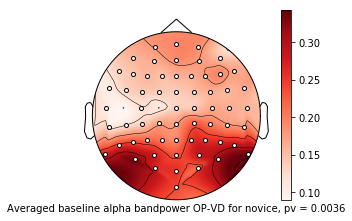

In [29]:
with open("/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/full_epochs_data/statistic/VDOP_alpha_baseline_Absnovice.txt", "rb") as fp:   # Unpickling
    bp = pickle.load(fp)
# bpAbs_mean4Epochs_VD4allsubjs = bp[0]
# bpAbs_mean4Epochs_FA4allsubjs = bp[1]

precleaned_epochs_fname = precleaned_epochs_path + 'subj004full_epo.fif'
precleaned_epochs = mne.read_epochs(precleaned_epochs_fname, preload=True)
connectivity, ch_names = find_ch_connectivity(precleaned_epochs.info, ch_type='eeg')

p_threshold = 0.05
# threshold = -t.ppf(p_threshold/2,np.expand_dims(bpAbs_mean4Epochs_VD4allsubjs,axis=1).shape[0]-1)
# cluster_stats = mne.stats.spatio_temporal_cluster_1samp_test(np.expand_dims(bpAbs_mean4Epochs_OP4allsubjs,axis=1)-np.expand_dims(bpAbs_mean4Epochs_VD4allsubjs,axis=1), 
#                                                              n_permutations=10000,tail=0,threshold=threshold,
#                                              n_jobs=2, buffer_size=None,verbose=True,
#                                              connectivity=connectivity)

threshold = -t.ppf(p_threshold/2,bp[0].shape[0]-1)
cluster_stats = mne.stats.spatio_temporal_cluster_1samp_test(bp[1]-bp[0], 
                                                             n_permutations=10000,tail=0,threshold=threshold,
                                             n_jobs=2, buffer_size=None,verbose=True,
                                             connectivity=connectivity)

# threshold = -t.ppf(p_threshold/2,np.expand_dims(bpAbs_mean4Epochs_FA4allsubjs,axis=1).shape[0]-1)
# cluster_stats = mne.stats.spatio_temporal_cluster_1samp_test(np.expand_dims(bpAbs_mean4Epochs_OP4allsubjs,axis=1)-np.expand_dims(bpAbs_mean4Epochs_FA4allsubjs,axis=1), 
#                                                              n_permutations=10000,tail=0,threshold=threshold,
#                                              n_jobs=2, buffer_size=None,verbose=True,
#                                              connectivity=connectivity)

T_obs, clusters, p_values, _ = cluster_stats
print(clusters)
good_cluster_inds = np.array(range(len(clusters)))
precleaned_epochs_fname = precleaned_epochs_path + 'subj004full_epo.fif'
precleaned_epochs = mne.read_epochs(precleaned_epochs_fname, preload=True)
pos = mne.find_layout(precleaned_epochs.info).pos
for i_clu, clu_idx in enumerate(good_cluster_inds):
    # unpack cluster information, get unique indices
    time_inds, space_inds = np.squeeze(clusters[clu_idx])
    ch_inds = np.unique(space_inds)
    time_inds = np.unique(time_inds)

    # get topography for bp-mean
#     bp_map = np.squeeze((np.expand_dims(bpAbs_mean4Epochs_OP4allsubjs,axis=1)-np.expand_dims(bpAbs_mean4Epochs_VD4allsubjs,axis=1)).mean(axis=0))
#     bp_map = np.squeeze((np.expand_dims(bpAbs_mean4Epochs_FA4allsubjs,axis=1)-np.expand_dims(bpAbs_mean4Epochs_VD4allsubjs,axis=1)).mean(axis=0))
    bp_map = np.squeeze((bp[1]-bp[0]).mean(axis=0))

    
    # create spatial mask
    mask = np.zeros((bp_map.shape[0], 1), dtype=bool)
    mask[ch_inds, :] = True

    # initialize figure
    fig, ax_topo = plt.subplots(1, 1, figsize=(10, 3))

    # plot average test statistic and mark significant sensors
    image, _ = mne.viz.plot_topomap(bp_map, pos, mask=mask, axes=ax_topo, cmap='Reds',
                            vmin=np.min, vmax=np.max, show=False)
    divider = make_axes_locatable(ax_topo)

    # add axes for colorbar
    ax_colorbar = divider.append_axes('right', size='5%', pad=0.05)
    plt.colorbar(image, cax=ax_colorbar)
#     ax_topo.set_xlabel('Averaged baseline alpha bandpower OP-VD for {}'.format(group))
    
    ax_topo.set_xlabel('Averaged baseline alpha bandpower OP-VD for novice, pv = {}'.format(p_values[i_clu]))

#     ax_topo.set_xlabel('Averaged baseline alpha bandpower OP-FA for {}'.format(group))
    
    mne.viz.tight_layout(fig=fig)
    fig.subplots_adjust(bottom=.05)
#     plt.show()
#     fig.savefig('/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/full_epochs_data/statistic/OP-VD_alpha_baseline topoplot.png')
    fig.savefig('/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/full_epochs_data/statistic/OP-VD_alpha_baseline_novice topoplot'+str(i_clu)+'.png')
#     fig.savefig('/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/full_epochs_data/statistic/OP-FA_alpha_baseline_novice topoplot'+str(i_clu)+'.png')



In [18]:
p_values

array([0.1628, 0.2247, 0.1584, 0.1844, 0.1157])

In [103]:
from scipy.stats.distributions import f,t
p_threshold = 0.05
threshold = -t.ppf(p_threshold/2,np.expand_dims(bpAbs_mean4Epochs_VD4allsubjs,axis=1).shape[0]-1)
cluster_stats = mne.stats.spatio_temporal_cluster_1samp_test(np.expand_dims(bpAbs_mean4Epochs_VD4allsubjs,axis=1)-np.expand_dims(bpAbs_mean4Epochs_OP4allsubjs,axis=1), 
                                                             n_permutations=10000,tail=0,threshold=threshold,
                                             n_jobs=1, buffer_size=None,verbose=True,
                                             connectivity=connectivity)
T_obs, clusters, p_values, _ = cluster_stats
clusters[0]
# good_cluster_inds = np.where(p_values < p_threshold)[0]
# good_cluster_inds

stat_fun(H1): min=-6.690775 max=-4.187748
Running initial clustering
Found 1 clusters
Permuting 9999 times...
[.....................................] 100.00%  |   
Computing cluster p-values
Done.


IndexError: list index out of range

In [108]:
clusters[0][1]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63])

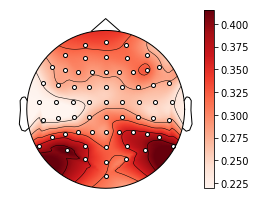

In [98]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
good_cluster_inds = np.array([0])
# precleaned_epochs_fname = precleaned_epochs_path + 'subj004full_epo.fif'
# precleaned_epochs = mne.read_epochs(precleaned_epochs_fname, preload=True)
pos = mne.find_layout(precleaned_epochs.info).pos
for i_clu, clu_idx in enumerate(good_cluster_inds):
    # unpack cluster information, get unique indices
    time_inds, space_inds = np.squeeze(clusters[clu_idx])
    ch_inds = np.unique(space_inds)
    time_inds = np.unique(time_inds)

    # get topography for bp-mean
    bp_map = np.squeeze(-(np.expand_dims(bpAbs_mean4Epochs_VD4allsubjs,axis=1)-np.expand_dims(bpAbs_mean4Epochs_OP4allsubjs,axis=1)).mean(axis=0))

    # create spatial mask
    mask = np.zeros((f_map.shape[0], 1), dtype=bool)
    mask[ch_inds, :] = True

    # initialize figure
    fig, ax_topo = plt.subplots(1, 1, figsize=(10, 3))

    # plot average test statistic and mark significant sensors
    image, _ = mne.viz.plot_topomap(bp_map, pos, mask=mask, axes=ax_topo, cmap='Reds',
                            vmin=np.min, vmax=np.max, show=False)
    divider = make_axes_locatable(ax_topo)

    # add axes for colorbar
    ax_colorbar = divider.append_axes('right', size='5%', pad=0.05)
    plt.colorbar(image, cax=ax_colorbar)

In [95]:
np.squeeze((np.expand_dims(bpAbs_mean4Epochs_VD4allsubjs,axis=1)-np.expand_dims(bpAbs_mean4Epochs_OP4allsubjs,axis=1)).mean(axis=0)).shape

(64,)

KeyboardInterrupt: 

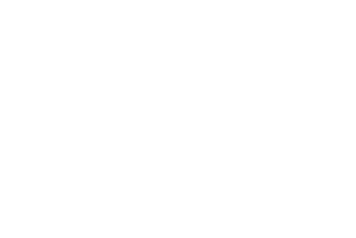

In [83]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
chan_coord=np.array([[-0.3088288, 0.9504773 ]])
mne.viz.plot_topomap(np.array([1.3]),pos=chan_coord,axes=ax)
mne.viz.tight_layout()

In [258]:
from mne.channels import find_ch_connectivity
connectivity, ch_names = find_ch_connectivity(precleaned_epochs.info, ch_type='eeg')

# set cluster threshold
threshold = 2 do not use
# set family-wise p-value
p_accept = 0.5
# threshold=threshold,

cluster_stats = mne.stats.spatio_temporal_cluster_test(bpRelative_mean4Epochs2test, n_permutations=1000,
                                              tail=1,n_jobs=1, buffer_size=None,
                                             connectivity=connectivity)

T_obs, clusters, p_values, _ = cluster_stats
good_cluster_inds = np.where(p_values < p_accept)[0]


Could not find a connectivity matrix for the data. Computing connectivity based on Delaunay triangulations.
-- number of connected vertices : 64
stat_fun(H1): min=0.065338 max=2.088040
Running initial clustering
Found 1 clusters
Permuting 999 times...
[.....................................] 100.00%  |   
Computing cluster p-values
Done.


In [56]:
### get psd matrix ###

## to save at the end 
# >>> from tempfile import TemporaryFile
# >>> outfile = TemporaryFile()
# >>> x = np.arange(10)
# >>> np.save(outfile, x)
# >>> _ = outfile.seek(0) # Only needed here to simulate closing & reopening file
# >>> np.load(outfile)
# array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
import numpy as np
import mne
from mne.time_frequency import psd_array_multitaper
subjs=['02', '04','07', '11', '12', '14', '16', '18', '19', '21', '22', '26', '28', '30',
       '32', '34', '36', '37', '38', '40', '42', '50', '51', '52', '53', '54', '55', '56',
       '58', '59','60', '63', '65', '67', '68', '70', '72', '73', '78', '83', '87', '88', 
       '90', '91', '93', '94', '95', '96','10','25','29','39','57','64','69','80','81','82',
       '35','71','79','76','77']


states_codes={'VD':['111.0','112.0'],
              'FA':['211.0','212.0'],
              'OP':['311.0','312.0']}

# create VD baseline
precleaned_epochs_path = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/full_epochs_data/'
psdList_mean4epochs4allSubjs = []
for subj in subjs:
    precleaned_epochs_fname = precleaned_epochs_path + 'subj0'+subj+'full_epo.fif'
    precleaned_epochs = mne.read_epochs(precleaned_epochs_fname, preload=True)
    precleaned_epochs_OP = precleaned_epochs[states_codes['OP']]
    data = precleaned_epochs_OP.get_data(picks=['eeg'])
    psd4epochs = []
    for num_epochs in range(data.shape[0]):
        sf = precleaned_epochs_OP.info['sfreq']
        psd, freqs = psd_array_multitaper(data[num_epochs], sf, fmin = 1, fmax =100,
                          adaptive=True,normalization='full',verbose=0)
        psd= np.log10(psd*10e12)
        psd4epochs.append(psd)
    psd_mean4epochs = np.append([psd4epochs[0]],psd4epochs[1:],axis = 0).mean(axis=0)
    psdList_mean4epochs4allSubjs.append(psd_mean4epochs)
psd_final = np.append([psdList_mean4epochs4allSubjs[0]],psdList_mean4epochs4allSubjs[1:],axis = 0)

np.save('/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/full_epochs_data/freq_channels4allSubjsOP.npy', psd_final)

Reading /home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/full_epochs_data/subj002full_epo.fif ...
    Found the data of interest:
        t =       0.00 ...    2000.00 ms
        0 CTF compensation matrices available
1288 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Reading /home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/full_epochs_data/subj004full_epo.fif ...
    Found the data of interest:
        t =       0.00 ...    2000.00 ms
        0 CTF compensation matrices available
1288 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Reading /home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/full_epochs_data/subj007full_epo.fif ...
    Found the data of interest:
        t =       0.00 ...    2000.00 ms
        0 CTF compensation matrices available
1282 matching events found
No baseline correction applied
Not setting metadata
0 p

Reading /home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/full_epochs_data/subj053full_epo.fif ...
    Found the data of interest:
        t =       0.00 ...    2000.00 ms
        0 CTF compensation matrices available
1540 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Reading /home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/full_epochs_data/subj054full_epo.fif ...
    Found the data of interest:
        t =       0.00 ...    2000.00 ms
        0 CTF compensation matrices available
1577 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Reading /home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/full_epochs_data/subj055full_epo.fif ...
    Found the data of interest:
        t =       0.00 ...    2000.00 ms
        0 CTF compensation matrices available
1480 matching events found
No baseline correction applied
Not setting metadata
0 p

Reading /home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/full_epochs_data/subj010full_epo.fif ...
    Found the data of interest:
        t =       0.00 ...    2000.00 ms
        0 CTF compensation matrices available
1207 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Reading /home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/full_epochs_data/subj025full_epo.fif ...
    Found the data of interest:
        t =       0.00 ...    2000.00 ms
        0 CTF compensation matrices available
1985 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Reading /home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/full_epochs_data/subj029full_epo.fif ...
    Found the data of interest:
        t =       0.00 ...    2000.00 ms
        0 CTF compensation matrices available
1498 matching events found
No baseline correction applied
Not setting metadata
0 p

In [59]:
psd_OP = np.load('/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/full_epochs_data/freq_channels4allSubjsOP.npy')
psd_OP.shape

(63, 64, 198)

In [11]:
# this script is aimed to add interpolated channel to precleaned_epochs
### important  not take into account eletrodes' positions

# import mne
# precleaned_epochs_path = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/full_epochs_data/'
# precleaned_epochs_fname = precleaned_epochs_path + 'subj077full_epo.fif'
# precleaned_epochs = mne.read_epochs(precleaned_epochs_fname, preload=True)
# precleaned_epochs.info['ch_names']
# epochs2E = precleaned_epochs.copy()
# epochs2E.pick_channels(['F1','F3'])
# epochs2E.info['ch_names']=['P9','P10']
# epochs2E.info['chs'][0]['ch_name']='P9'
# epochs2E.info['chs'][1]['ch_name']='P10'
# precleaned_epochs.add_channels([epochs2E])
# precleaned_epochs.info['bads']=['P9','P10']
# precleaned_epochs.interpolate_bads()
# precleaned_epochs.save(precleaned_epochs_fname)

<ipython-input-11-cbde4e9a742a>:14: DeprecationWarning: overwrite defaults to True in 0.18 but will change to False in 0.19, set it explicitly to avoid this warning
  precleaned_epochs.save(precleaned_epochs_fname)


In [210]:
## save list
import pickle
with open("VDOP_alpha_Abs.txt", "wb") as fp:   #Pickling
pickle.dump(bpAbs_mean4Epochs2test, fp)
with open("VDOP_alpha_Relative.txt", "wb") as fp:   #Pickling
pickle.dump(bpAbs_mean4Epochs2test, fp)
# >>> with open("test.txt", "rb") as fp:   # Unpickling
# ...   b = pickle.load(fp)


(0, 1)

ValueError: Input passed into argument "'x'"is not 1-dimensional.

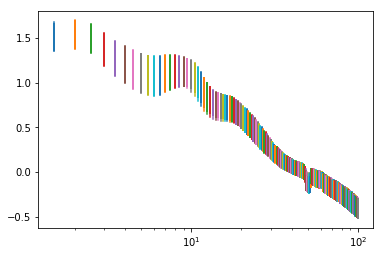

In [75]:
# of no interest psd plot
psd_OP = np.load('/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/full_epochs_data/freq_channels4allSubjsOP.npy')
plt.figure()
average = psd_OP.mean(axis=0)
# average.shape
sem = psd_OP.std(axis = 0)/np.sqrt(psd_OP.shape[0])
plt.semilogx(freqs,average)
plt.fill_between(freqs,average+sem,average-sem,alpha=.4)
plt.title('Average PSD for all subjs for all channels')
plt.legend('OP')
plt.show()


In [3]:
### get bp matrice for 6 baseline  expert/novice  VD FA OP -baseline  local version

import pickle
import mne
import matplotlib.pyplot as plt
from mne.time_frequency import psd_array_multitaper
from scipy.integrate import simps
import numpy as np
import seaborn as sns
import pandas as pd
import sys
from mne.channels import find_ch_connectivity
from scipy.stats.distributions import f,t
from mpl_toolkits.axes_grid1 import make_axes_locatable
precleaned_epochs_path = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/full_epochs_data/'
fmin = 1
fmax = 100
def getBpAbsAndRelative4allChannels(epochs,rhythm):
    wavebands = {'alpha':[8,12],'theta':[3,7],'beta':[13,24],'lowG':[25,40],'highG':[60,90]}
    if rhythm in wavebands.keys():
        low,high =  wavebands[rhythm]
    else:
        print('not such rhythm')
    bpAbs_4Epochs=[]
    bpRelative_4Epochs=[]
    data = epochs.get_data(picks=['eeg'])
    for num_epochs in range(data.shape[0]):
        sf = epochs.info['sfreq']
        bpAbs_4allchannels = []
        bpRelative_4allchannels = []
        psd, freqs = psd_array_multitaper(data[num_epochs], sf, fmin = 1, fmax =100,
                          adaptive=True,normalization='full',verbose=0)
        psd= np.log10(psd*10e12)
        freq_res = freqs[1] - freqs[0]
        bp_total = simps(psd, dx=freq_res)
        idx_band = np.logical_and(freqs >= low, freqs <= high)
        bp_abs = simps(psd[:,idx_band], dx=freq_res)
        bp_relative = bp_abs/bp_total
        bpAbs_4Epochs.append(bp_abs)
        bpRelative_4Epochs.append(bp_relative)
    bpAbs_mean4Epochs = np.append([bpAbs_4Epochs[0]],bpAbs_4Epochs[1:],axis = 0).mean(axis=0)
    bpRelative_mean4Epochs = np.append([bpRelative_4Epochs[0]],bpRelative_4Epochs[1:],axis = 0).mean(axis=0)
    return bpAbs_mean4Epochs,bpRelative_mean4Epochs

def getBpAbs4allChannels(epochs,rhythm):
    wavebands = {'alpha':[8,12],'theta':[3,7],'beta':[13,24],'lowG':[25,40],'highG':[60,90]}
    if rhythm in wavebands.keys():
        low,high =  wavebands[rhythm]
    else:
        print('not such rhythm')
    bpAbs_4Epochs=[]
    data = epochs.get_data(picks=['eeg'])
    for num_epochs in range(data.shape[0]):
        sf = epochs.info['sfreq']
        bpAbs_4allchannels = []
        psd, freqs = psd_array_multitaper(data[num_epochs], sf, fmin = 1, fmax =100,
                          adaptive=True,normalization='full',verbose=0)
        psd= np.log10(psd*10e12)
        freq_res = freqs[1] - freqs[0]
        idx_band = np.logical_and(freqs >= low, freqs <= high)
        bp_abs = simps(psd[:,idx_band], dx=freq_res)
        bpAbs_4Epochs.append(bp_abs)
    bpAbs_mean4Epochs = np.append([bpAbs_4Epochs[0]],bpAbs_4Epochs[1:],axis = 0).mean(axis=0)
    return bpAbs_mean4Epochs

# alpha bp clustering test - VD OP

subjs=['02', '04','07', '11', '12', '14', '16', '18', '19', '21', '22', '26', '28', '30',
       '32', '34', '36', '37', '38', '40', '42', '50', '51', '52', '53', '54', '55', '56',
       '58', '59','60', '63', '65', '67', '68', '70', '72', '73', '78', '83', '87', '88', 
       '90', '91', '93', '94', '95', '96','10','25','29','39','57','64','69','80','81','82',
       '35','71','79','76','77']

# states_codes={'VD':['111.0','112.0','121.0','122.0','131.0','132.0'],
#               'FA':['211.0','212.0','221.0','222.0','231.0','232.0'],
#               'OP':['311.0','312.0','321.0','322.0','331.0','332.0']}

states_codes={'VD':['111.0','112.0'],
              'FA':['211.0','212.0'],
              'OP':['311.0','312.0']}

listNovices = ['02', '04', '07', '10', '11', '12', '14', '16', '18', '19', '21', '22', '26', 
 '28', '29', '30', '32', '34', '35', '36', '37', '38','39', '40', '42', '81', '82', 
 '83', '87', '88', '90', '91', '93', '94', '95', '96']
listExperts = ['25', '50','51', '52']
#  '53', '54', '55', '56', '57', '58', '59', '60', '63', '64', '65', '67','68', '69' ,'70' ,
#                '71', '72', '73', '76', '77', '78' ,'79', '80']

# group = sys.argv[1]
group = 'expert'
bpAbs_mean4Epochs_VD4allsubjs = np.array([])
bpAbs_mean4Epochs_FA4allsubjs = np.array([])
bpAbs_mean4Epochs_OP4allsubjs = np.array([])
if group == 'expert':
    subjs = listExperts
elif group == 'novice':
    subjs = listNovices
else:
    print('no such group')
for subj in subjs:
    precleaned_epochs_fname = precleaned_epochs_path + 'subj0'+subj+'full_epo.fif'
    precleaned_epochs = mne.read_epochs(precleaned_epochs_fname, preload=True)
    
#     precleaned_epochs_VD = precleaned_epochs[states_codes['VD']]
#     precleaned_epochs_OP = precleaned_epochs[states_codes['OP']]
#     bpAbs_mean4Epochs_VD = getBpAbs4allChannels(precleaned_epochs_VD,'alpha')
#     bpAbs_mean4Epochs_OP= getBpAbs4allChannels(precleaned_epochs_OP,'alpha')

#     precleaned_epochs_VD = precleaned_epochs[states_codes['VD']]
#     precleaned_epochs_FA = precleaned_epochs[states_codes['FA']]
#     bpAbs_mean4Epochs_VD = getBpAbs4allChannels(precleaned_epochs_VD,'alpha')
#     bpAbs_mean4Epochs_FA= getBpAbs4allChannels(precleaned_epochs_FA,'alpha')

    precleaned_epochs_FA = precleaned_epochs[states_codes['FA']]
    precleaned_epochs_OP = precleaned_epochs[states_codes['OP']]
    bpAbs_mean4Epochs_FA = getBpAbs4allChannels(precleaned_epochs_FA,'alpha')
    bpAbs_mean4Epochs_OP= getBpAbs4allChannels(precleaned_epochs_OP,'alpha')
    
#     if len(bpAbs_mean4Epochs_VD4allsubjs)==0:
#         bpAbs_mean4Epochs_VD4allsubjs = bpAbs_mean4Epochs_VD
# #         bpRelative_mean4Epochs_VD4allsubjs = bpRelative_mean4Epochs_VD
#     else:
#         bpAbs_mean4Epochs_VD4allsubjs = np.vstack((bpAbs_mean4Epochs_VD4allsubjs,bpAbs_mean4Epochs_VD))
# #         bpRelative_mean4Epochs_VD4allsubjs = np.vstack((bpRelative_mean4Epochs_VD4allsubjs,
# #                                                         bpRelative_mean4Epochs_VD))
        
    if len(bpAbs_mean4Epochs_OP4allsubjs)==0:
        bpAbs_mean4Epochs_OP4allsubjs = bpAbs_mean4Epochs_OP
#         bpRelative_mean4Epochs_OP4allsubjs = bpRelative_mean4Epochs_OP
    else:
        bpAbs_mean4Epochs_OP4allsubjs = np.vstack((bpAbs_mean4Epochs_OP4allsubjs,bpAbs_mean4Epochs_OP))
#         bpRelative_mean4Epochs_OP4allsubjs = np.vstack((bpRelative_mean4Epochs_OP4allsubjs,
#                                                         bpRelative_mean4Epochs_OP))

    if len(bpAbs_mean4Epochs_FA4allsubjs)==0:
        bpAbs_mean4Epochs_FA4allsubjs = bpAbs_mean4Epochs_FA
#         bpRelative_mean4Epochs_OP4allsubjs = bpRelative_mean4Epochs_OP
    else:
        bpAbs_mean4Epochs_FA4allsubjs = np.vstack((bpAbs_mean4Epochs_FA4allsubjs,bpAbs_mean4Epochs_FA))
#         bpRelative_mean4Epochs_OP4allsubjs = np.vstack((bpRelative_mean4Epochs_OP4allsubjs,
#                                                         bpRelative_mean4Epochs_OP))
        
# bpAbs_mean4Epochs2test = [np.expand_dims(bpAbs_mean4Epochs_VD4allsubjs,axis=1),
#                           np.expand_dims(bpAbs_mean4Epochs_OP4allsubjs,axis=1)]

# bpAbs_mean4Epochs2test = [np.expand_dims(bpAbs_mean4Epochs_VD4allsubjs,axis=1),
#                           np.expand_dims(bpAbs_mean4Epochs_FA4allsubjs,axis=1)]

bpAbs_mean4Epochs2test = [np.expand_dims(bpAbs_mean4Epochs_FA4allsubjs,axis=1),
                          np.expand_dims(bpAbs_mean4Epochs_OP4allsubjs,axis=1)]


# with open('/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/full_epochs_data/statistic/VDOP_alpha_baseline_Abs'+group+'.txt', "wb") as fp:   #Pickling
#     pickle.dump(bpAbs_mean4Epochs2test, fp)
    
# with open('/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/full_epochs_data/statistic/VDFA_alpha_baseline_Abs'+group+'.txt', "wb") as fp:   #Pickling
#     pickle.dump(bpAbs_mean4Epochs2test, fp)
with open('/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/full_epochs_data/statistic/FAOP_alpha_baseline_Abs'+group+'.txt', "wb") as fp:   #Pickling
    pickle.dump(bpAbs_mean4Epochs2test, fp)
    
precleaned_epochs_fname = precleaned_epochs_path + 'subj004full_epo.fif'
precleaned_epochs = mne.read_epochs(precleaned_epochs_fname, preload=True)
connectivity, ch_names = find_ch_connectivity(precleaned_epochs.info, ch_type='eeg')

p_threshold = 0.05
# threshold = -t.ppf(p_threshold/2,np.expand_dims(bpAbs_mean4Epochs_VD4allsubjs,axis=1).shape[0]-1)
# cluster_stats = mne.stats.spatio_temporal_cluster_1samp_test(np.expand_dims(bpAbs_mean4Epochs_OP4allsubjs,axis=1)-np.expand_dims(bpAbs_mean4Epochs_VD4allsubjs,axis=1), 
#                                                              n_permutations=10000,tail=0,threshold=threshold,
#                                              n_jobs=2, buffer_size=None,verbose=True,
#                                              connectivity=connectivity)

# threshold = -t.ppf(p_threshold/2,np.expand_dims(bpAbs_mean4Epochs_VD4allsubjs,axis=1).shape[0]-1)
# cluster_stats = mne.stats.spatio_temporal_cluster_1samp_test(np.expand_dims(bpAbs_mean4Epochs_FA4allsubjs,axis=1)-np.expand_dims(bpAbs_mean4Epochs_VD4allsubjs,axis=1), 
#                                                              n_permutations=10000,tail=0,threshold=threshold,
#                                              n_jobs=2, buffer_size=None,verbose=True,
#                                              connectivity=connectivity)

threshold = -t.ppf(p_threshold/2,np.expand_dims(bpAbs_mean4Epochs_FA4allsubjs,axis=1).shape[0]-1)
cluster_stats = mne.stats.spatio_temporal_cluster_1samp_test(np.expand_dims(bpAbs_mean4Epochs_OP4allsubjs,axis=1)-np.expand_dims(bpAbs_mean4Epochs_FA4allsubjs,axis=1), 
                                                             n_permutations=10000,tail=0,threshold=threshold,
                                             n_jobs=2, buffer_size=None,verbose=True,
                                             connectivity=connectivity)

T_obs, clusters, p_values, _ = cluster_stats
print(clusters)
good_cluster_inds = np.array(range(len(clusters)))
precleaned_epochs_fname = precleaned_epochs_path + 'subj004full_epo.fif'
precleaned_epochs = mne.read_epochs(precleaned_epochs_fname, preload=True)
pos = mne.find_layout(precleaned_epochs.info).pos
for i_clu, clu_idx in enumerate(good_cluster_inds):
    # unpack cluster information, get unique indices
    time_inds, space_inds = np.squeeze(clusters[clu_idx])
    ch_inds = np.unique(space_inds)
    time_inds = np.unique(time_inds)

    # get topography for bp-mean
#     bp_map = np.squeeze((np.expand_dims(bpAbs_mean4Epochs_OP4allsubjs,axis=1)-np.expand_dims(bpAbs_mean4Epochs_VD4allsubjs,axis=1)).mean(axis=0))
#     bp_map = np.squeeze((np.expand_dims(bpAbs_mean4Epochs_FA4allsubjs,axis=1)-np.expand_dims(bpAbs_mean4Epochs_VD4allsubjs,axis=1)).mean(axis=0))
    bp_map = np.squeeze((np.expand_dims(bpAbs_mean4Epochs_OP4allsubjs,axis=1)-np.expand_dims(bpAbs_mean4Epochs_FA4allsubjs,axis=1)).mean(axis=0))

    
    # create spatial mask
    mask = np.zeros((bp_map.shape[0], 1), dtype=bool)
    mask[ch_inds, :] = True

    # initialize figure
    fig, ax_topo = plt.subplots(1, 1, figsize=(10, 3))

    # plot average test statistic and mark significant sensors
    image, _ = mne.viz.plot_topomap(bp_map, pos, mask=mask, axes=ax_topo, cmap='Reds',
                            vmin=np.min, vmax=np.max, show=False)
    divider = make_axes_locatable(ax_topo)

    # add axes for colorbar
    ax_colorbar = divider.append_axes('right', size='5%', pad=0.05)
    plt.colorbar(image, cax=ax_colorbar)
#     ax_topo.set_xlabel('Averaged baseline alpha bandpower OP-VD for {}'.format(group))
    
#     ax_topo.set_xlabel('Averaged baseline alpha bandpower FA-VD for {}'.format(group))

    ax_topo.set_xlabel('Averaged baseline alpha bandpower OP-FA for {}'.format(group))
    
    mne.viz.tight_layout(fig=fig)
    fig.subplots_adjust(bottom=.05)
#     plt.show()
#     fig.savefig('/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/full_epochs_data/statistic/OP-VD_alpha_baseline topoplot.png')
#     fig.savefig('/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/full_epochs_data/statistic/FA-VD_alpha_baseline topoplot'+'i_clu'+'.png')
    fig.savefig('/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/full_epochs_data/statistic/OP-FA_alpha_baseline topoplot'+'i_clu'+'.png')



Reading /home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/full_epochs_data/subj025full_epo.fif ...
    Found the data of interest:
        t =       0.00 ...    2000.00 ms
        0 CTF compensation matrices available
1985 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Reading /home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/full_epochs_data/subj050full_epo.fif ...
    Found the data of interest:
        t =       0.00 ...    2000.00 ms
        0 CTF compensation matrices available
1472 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Reading /home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/full_epochs_data/subj051full_epo.fif ...
    Found the data of interest:
        t =       0.00 ...    2000.00 ms
        0 CTF compensation matrices available
1525 matching events found
No baseline correction applied
Not setting metadata
0 p

<ipython-input-3-c186e6ddaac9>:182: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  connectivity=connectivity)


1288 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
